# Structured API

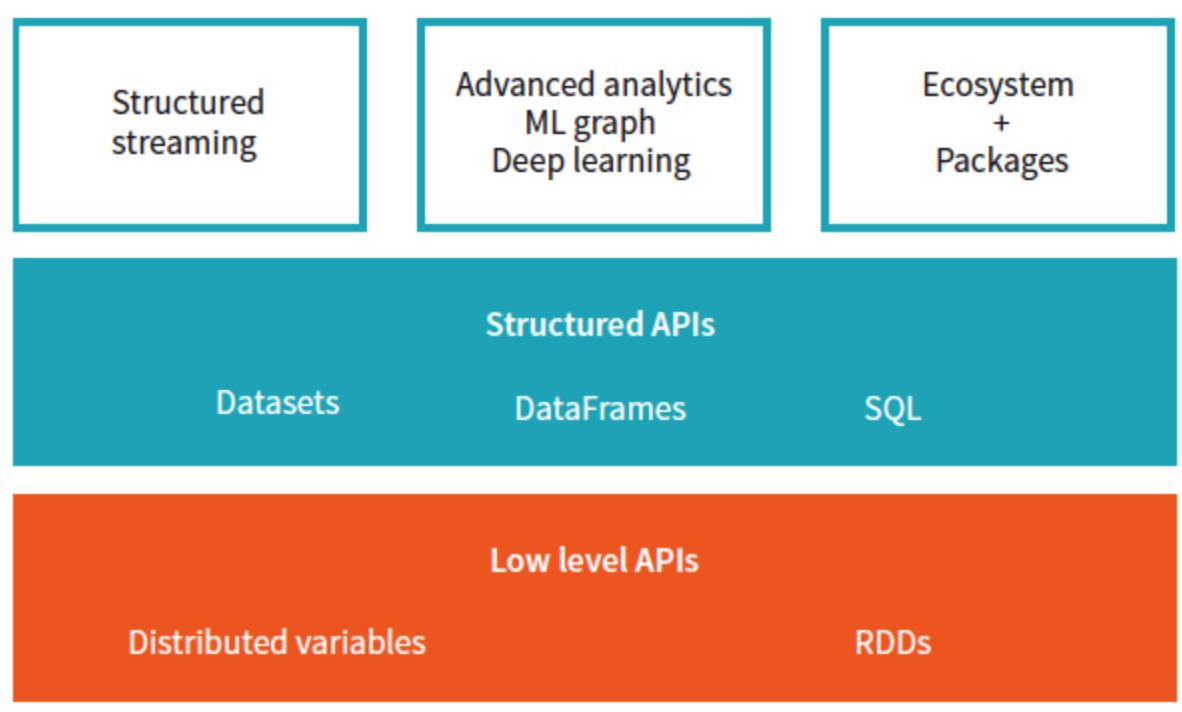

In [101]:
from IPython.display import Image
Image("Screen Shot 2018-07-12 at 16.46.59.png",width=300)

Yukarıda gördüğünüz gibi spark,Yapılandırılmış Api'ler(Structured) ve low level api'lere sahip,Buradaki structured api bizim elimizdeki tüm veri tipleri için manipülasyonlar sağlayan araçtır.Datasets,DataFrames,SQL,log file,csv files,parquet files gibi.

<strong>Datasets,DataFrames</strong>:Spark'da dataset ve DataFrame dağıtılmış tablo benzeri satır ve sütunlardan oluşan yapılardır.Her sütun eşit sayıda satırdan oluşmaktadır,ve her sutünun içindeki veri tipi diğer satırlardaki ile tutarlı olmaılıdır.<p>
<strong>Schemas</strong>:Şema'da DataFrame'in sutünlarının isimlerini ve veri tiplerini ifade eden yapıdır.<p>
  Table ve view'ler aslında dataFrame ile aynı şeylerdir sadece biz spark'da sql sorgularını direk olarak çalıştırabilmek için view oluşturuyoruz.

ve eklemek gerekirse eğer biz spark ve ya R dan structured api kullanırsak bizim yaptığımız manipulasyonlar Spark type'ları üzerinden olacaktır.Bunuda içinde barındırdıgı catalayst motoru ile yapar.Bu motor spark'ın kendine ait veri tipi bilgilerini koruyan bir yapıdır.örnek vermek gerekirse Alttaki kod pyhton'da çalışmaz tamamı spark içinde çalışır.

In [102]:
df=spark.range(100).toDF("hundred")
df.select(df["hundred"]+10).show(4)


df.createOrReplaceTempView("yuz")
spark.sql("select hundred+10 as yuz from yuz").show(4)

+--------------+
|(hundred + 10)|
+--------------+
|            10|
|            11|
|            12|
|            13|
+--------------+
only showing top 4 rows

+---+
|yuz|
+---+
| 10|
| 11|
| 12|
| 13|
+---+
only showing top 4 rows



Yukarıda gördüğünüz gibi DataFrame oluşturduğumuz ilk örnek o api üzerimdeli select methodu ile tüm satırları 10 ile toplayıp gösteriyor Ve yukarıda bahsettiğimiz aslında DataFrame ile view yada tablo'nun aynı şey olduğu sadece alt tarafında gördüğünüz gibi sql sorgularını direk geçirmek için kullanıyoruz.

Bu arada çok önemli olmamasına rağmen DataFrame ile Dataset arasındaki ufak farkı vermeden de geçmeyelim.
Tek fark DataFrame'in tip kontrolü Çalışma sırasında,DataSet'inki ise derleme zamanında yapılır.

###### Spark veri tipleri

Spark üzerinde hemen hemen tüm veri tipleri tanımlanabilir bunlara aşağıdaki şekilde ulaşabilir ve kullanabilirsiniz.


In [103]:
from pyspark.sql.types import *
b=ByteType()
b=4

Spark'daki sql tipleri hakkında daha detaylı bilgiyi <a href="https://spark.apache.org/docs/1.5.2/api/java/org/apache/spark/sql/types/package-summary.html">buradan</a> bulabilirisiniz.

###### Structured Api Nasıl Çalışır ?

Öncelikle spark'da yaptığımız,yazdığımız manipülasyonlar 4 aşamadan geçer DataFrame/Dataset, yada sql sorgusu yazılır bu spark Sessionunda sorgulanır,doğrulanır ve catalyst optimizer'a geçer sonra optimizer bunu logical plan'a çevirir Logical plandan sonra optimizer  logical planı pyhsical plana çevirir ve en son çalıştırır.

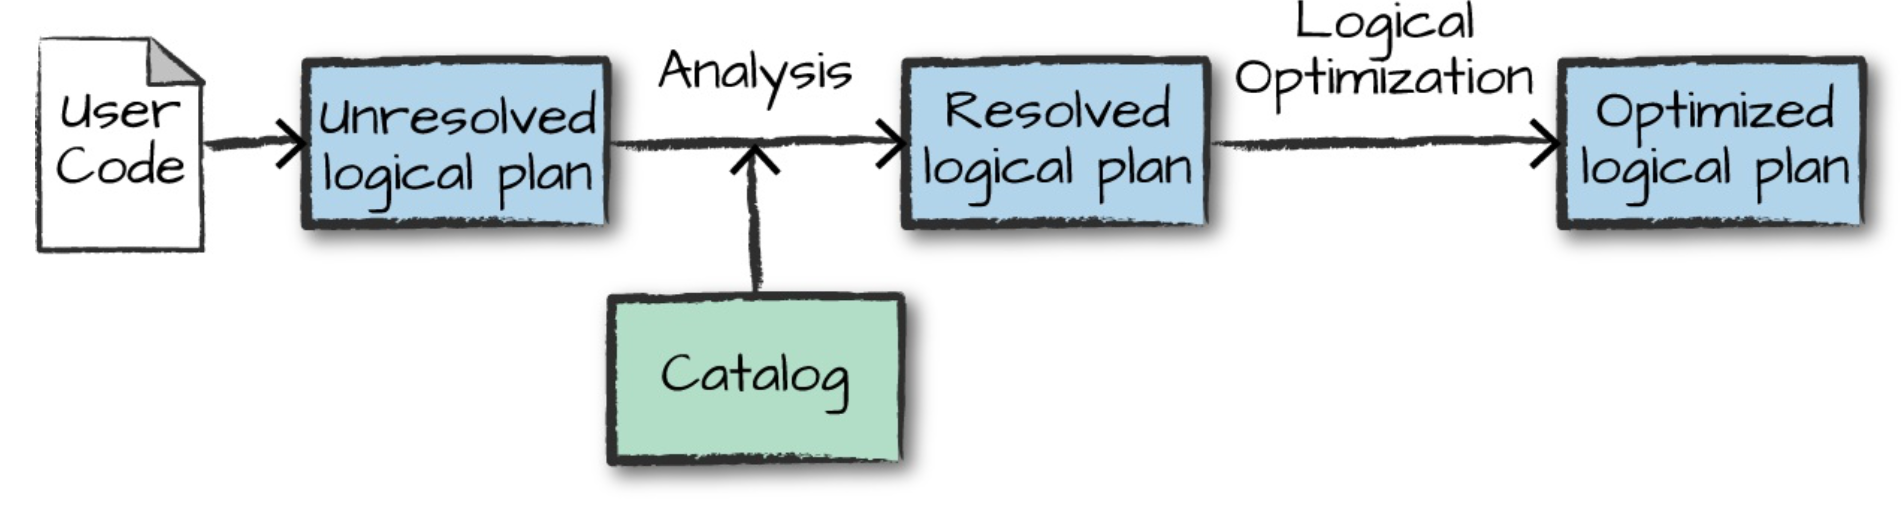

In [104]:
Image("Screen Shot 2018-07-12 at 18.38.48.png")

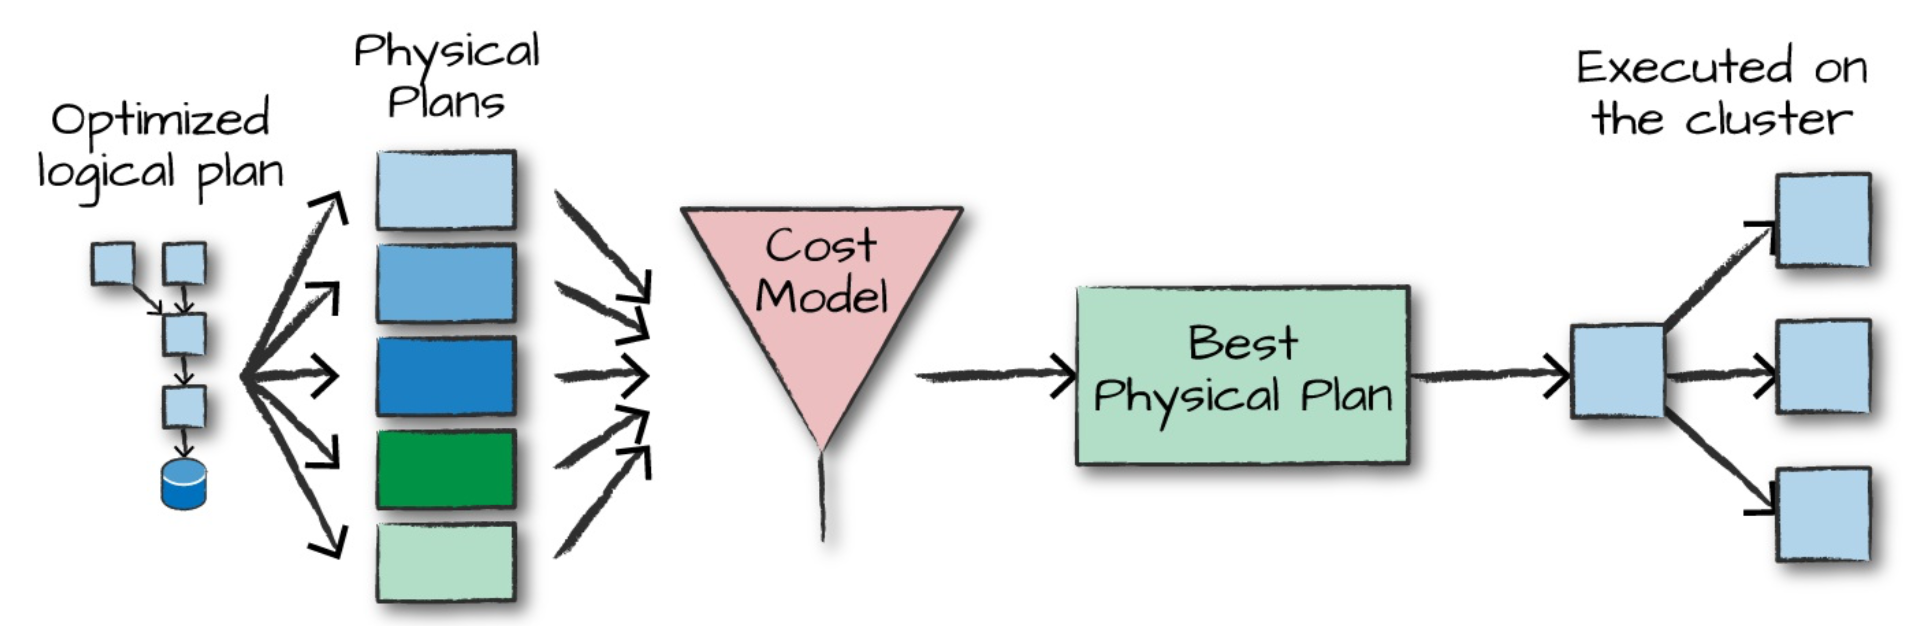

In [105]:
Image("Screen Shot 2018-07-12 at 18.47.09.png")

Tekrar tek tek anlatmak gerekirse:
<ol>
    <li> ilk olarak Kullanıcıdan alınan kod Çözümlenmemiş logical Plan(Unresolved Logical Plan) olarak alınır ve DataFrame'lerin çözümlemelerini ve doğruluklarını yapabilmek için <strong>Catalog</strong> kullanarak analiz yapar ve sonrasında kodu <strong>Catalyst Optimizer</strong>'e geçirir ve orada optimize edilir </li>
    <li>Optimize edilmiş logical plan'dan sonra Spark pyhsical plan için bir process başlatır burada ise artık logical planın cluster üzerinde nasıl çalıştırılcağına dair belirli stratejiler üretir ve bunları bir maliyet karşılaştırması(Cost Model) yaparak en iyisini seçmeye çalışır.(Örnek vermek gerekirse karşılaştırma ne kadar büyük bir tablonun ne kadar node üzerine dağıtıldığına göre belirlenebilir) ve sonra rdd ve transformationlar belirlenir.Şimdi Bu kısım aslında spark'ın Compile tarafı çünkü spark bizden DataFrame,DataSets,Sql kodlarını alıp bunu ilk fotoğraftada görebileceğiniz bir alt seviyeye Rdd transformationslara yani bir alt katmana derliyor.</li>
    <li>Son olarak Artık spark kullanıcıdan alınıp son haline gelen kodun hepsini rdd üzerinden çalıştırıyor ve ekstra olarak tüm kodu çalışma zamanında javabyte koda çevirerek onun üzerinde de bazı optimizasyonlar yapılıyor.Ve sonuç dönderiliyor.</li>
</ol>

## Temel Yapısal İşlemler

Bazı yapılandırışmış işlemlere girmeden önce birkaç kavramı açıklayalım.Bildiğimiz üzere DataFrame'ler alt alta dizilmiş kayıtlardan oluşuyor.Bu tablolardaki sütun isimlerini ve tiplerini tutan yapıya
<strong>Schema</strong> demiştik,<strong>Partition</strong>'a elimizdeki Dataset'in bir parçası diyebiliriz.Yani spark  bildiğimiz gibi bir Dataset'i alıyor paraçalara ayırıyor ve node'lara  dağıtıyor.Bu dağıtma işleminin adı ve  nasıl dağılacağını belirleyen <strong>Partitioting</strong>, dağılan veri parçalaranının nereye yerleşeceğini nasıl yerleşeceğini ise <strong>Partitioting Schema</strong> belirler.<p>Spark partition 1 eşzamanlı işlem yapabilir yani eğer bizim cluster'ımız 20 Core'dan oluşuyorsa spark aynı anda 20 farklı partiton çalıştırabilir yani cluster ne kadar büyükse partition'lar küçülür ne kadar küçükse partition'lar o kadar büyük hale gelir.Tabi her zaman verileri parçalayıp Node'lara dağıtmak verimli olmayabilir mesela ufak bir veri seti düşünün ve büyük bir veri tablosu ile join işlemi yapılacak bu verisetini tüm cluster üzerinde dağıtıp tek tek toplayıp işlem yapmak yerine tüm ağ üzerine(hub)gibi yayıp yani her node'a bir kopyasını gönererek çalıştırmak daha verimli olacaktır.

şimdi konuyu anlamak için biraz alıştırma yapalım öncelikle <a href="http://jsonstudio.com/resources/">buradan</a>,dosyasını indirip proje dizinine atalım sonrada aldığımız DataFrame olarak aldığımız verisetinin sutünlarındaki tip ve isim bilgielrini gösterelim.

Şimdi aşağıdaki örnekte schema'nın bizim dataFrame'mimizdeki sütunlarındaki tip ve isim bilgilerini tanımladığını söylemiştik,zaten dataFrame için biz açık şekilde schema oluşturmasaydık spark bunu zaten  okuma esnasında yapcaktı(schema-on read ).Eğer veriSetinin içideki verilerin tipleri schema ile örtüşmez ise çalışma esnasında spark bir hata yakalar.

In [2]:
df=spark.read.json("world_bank.json")
df.printSchema


<bound method DataFrame.printSchema of DataFrame[_id: struct<$oid:string>, approvalfy: string, board_approval_month: string, boardapprovaldate: string, borrower: string, closingdate: string, country_namecode: string, countrycode: string, countryname: string, countryshortname: string, docty: string, envassesmentcategorycode: string, grantamt: bigint, ibrdcommamt: bigint, id: string, idacommamt: bigint, impagency: string, lendinginstr: string, lendinginstrtype: string, lendprojectcost: bigint, majorsector_percent: array<struct<Name:string,Percent:bigint>>, mjsector_namecode: array<struct<code:string,name:string>>, mjtheme: array<string>, mjtheme_namecode: array<struct<code:string,name:string>>, mjthemecode: string, prodline: string, prodlinetext: string, productlinetype: string, project_abstract: struct<cdata:string>, project_name: string, projectdocs: array<struct<DocDate:string,DocType:string,DocTypeDesc:string,DocURL:string,EntityID:string>>, projectfinancialtype: string, projectstatu

StructType(List(StructField(_id,StructType(List(StructField($oid,StringType,true))),true),...)
<p>Struct Type gördüğünüz gibi alan sayısından oluşan bir listeyi tutar, ve StructField ise sütun bilgilerini ve tiplerini tutar ve eğer o alanın nulll değişken içerip içermediğine bağlı olarak booolen bir değer tutar.


In [4]:
from pyspark.sql.types import StructType,StructField,StringType,LongType,Row,IntegerType,NullType


In [6]:
data=[Row(1,"abdullah"),Row(2,"harun"),Row(3,None)]
#Buradaki None için Schema tanımlarken ilgili kısmın boolean
#değişkenini false yaparsanız spark null değişkene derleme sırasında izin vermeyecektir.
#rdd=sc.parallelize(data)
mySchema=StructType([StructField("number",IntegerType(),True),StructField("name",StringType(),True)])

In [7]:
df=spark.createDataFrame(data,mySchema)
df.show()



+------+--------+
|number|    name|
+------+--------+
|     1|abdullah|
|     2|   harun|
|     3|    null|
+------+--------+



Şimdi yukarıda gördüğünüz gibi spark içeresinde bir row listesi oluşturduk ve  onun şemasını belirleyip spark içeresinde bir dataFrame oluşturduk.Şimdi yukarıda StructField içerindeki True,False alabilen alanlar DataFrame içerinde null değişkeninin kullanılabilir olduğunu onaylar,şöyleki eğer "name" structField'inin True değerini false yaparsak artık o sütun için null değeri kullanılabilir olmaz ve spark bir hata verir.

In [9]:
from pyspark.sql.functions import col
number=col("number")
df.select(number).show()

+------+
|number|
+------+
|     1|
|     2|
|     3|
+------+



Yukarıdaki kod parçasıda spark içerisinde column'un nasıl kullanıbileceği konusunda ufak bir fikir vermek amacıyla yazılmıştır.Row fonksiyonu ile bir dizi oluşturup bunu rahatlıkla kendi oluşturduğumuz schema ile dataframe olarak çekip gördüğünüz gibi col ilede bu dataFrame içerisinden number ile tanımlı column'umuzu çektik.;

Şimdi biraz sütunlar üzerinde alıştırmalar yapalım,column üzerinde biz matematiksel işlemler  tanımlayabiliyoruz yani bir sütunun tüm kayıtlarını bir sayı ile çarpıp yada toplayabiliriz aşağıda da bunun ufak bir örneğini görülebilir.

In [10]:
a=(number+1)<number
df.select(a).show()
#from pyspark.sql.functions import expr
#a=expr("(number+1)<number") Yukarıdaki kod aynı şekilde sql function içinde ki expr methodu ilede yapılabilir.

+-----------------------+
|((number + 1) < number)|
+-----------------------+
|                  false|
|                  false|
|                  false|
+-----------------------+



Böyleliklede spark da bir dataframe nasıl oluşturulur ve o dataFrame'in sütun ve satırları nasıl oluşturulur ve kullanılır görmüş olduk şimdi de biraz de dataFrame'ler üzerinde transformation'lar nasıl yapılır onlara bakalım.

In [12]:
newDf=df.selectExpr("*","number+1 as a")
newDf.show()

+------+--------+---+
|number|    name|  a|
+------+--------+---+
|     1|abdullah|  2|
|     2|   harun|  3|
|     3|    null|  4|
+------+--------+---+



Gördüğünüz gibi selectExpr ile dataframinize bir sütun ekleyip başka bir dataFrame'e atayabiliyoruz
Şimdi de sabit bir değeri bir sütuna nasıl atayacağımza bakalım


In [15]:
from pyspark.sql.functions import lit



Gelin bir de direk dataFrame'e bir sütun nasıl ekleyeceğimize bakalım

In [20]:
newDf.withColumn("numberOne",lit(2)<3).show()#gördüğünüz gibi burda dirak newDf dataFrame i üzerinde değişiklik yapıyoruz.
newDf.withColumnRenamed("number","digit")# sütunları yeniden isimlendirmemize yarayan method.

+------+--------+---+---------+
|number|    name|one|numberOne|
+------+--------+---+---------+
|     1|abdullah|  1|     true|
|     2|   harun|  1|     true|
|     3|    null|  1|     true|
+------+--------+---+---------+



DataFrame[digit: int, name: string, one: int]


Yukarıdaki kod parçası df dataFrme'inden seçtiğimiz columnun tüm kayıtlarının 1 toplamı  ile normal değerlerini karşılaştırıp bir  sütun değişkenine boolen değeri atıyor

In [22]:
newDf2=newDf.withColumnRenamed("name","A digit")
newDf2.show()
newDf2.createOrReplaceTempView("data")

+------+--------+---+
|number| A digit|one|
+------+--------+---+
|     1|abdullah|  1|
|     2|   harun|  1|
|     3|    null|  1|
+------+--------+---+



Şimdi buraya kadar gelmişken bazen spark üzerinde  çalışırken karşılaşabileceğimiz durumlara değinmemek olmaz  newDf2 dataFrame'i gördüğünüz gibi boşluklu bir isime sahip bunun sql sorgularında üstesinden gelebilmek için spark `(backtick) kullanır sütun adını okumak için ancak spark içerisindeki sutün fonksiyonları  withColumn vb.  paramatreleri string olarak aldığı için " ` " kullanmaya gerek yoktur.

In [23]:
newDf2.selectExpr("`A digit`").show()

+--------+
| A digit|
+--------+
|abdullah|
|   harun|
|    null|
+--------+



Yeri gelmişken şunuda ekleyelim spark büyük harf küçük harf hassasiyetinden bağımsızdır ancak istersek bunu aşağıdaki fonksiyonla değiştirebiliriz.
    `set spark.sqlCaseSensitive true` #komutu ile değiştirebilirsiniz

spark da sütunlar hakkında 2-3 methodumuz daha kaldı onlarıda kısaca gösterip satır işlemlerine geçelim.

In [25]:
newDf2.drop("number").columns#bu method column silmek için kullanılır.
newDf2.withColumn("A digit1",col("A digit").cast("long")).show()#sutündaki değerin tipini değiştirmek için kullanılır.


+------+--------+---+--------+
|number| A digit|one|A digit1|
+------+--------+---+--------+
|     1|abdullah|  1|    null|
|     2|   harun|  1|    null|
|     3|    null|  1|    null|
+------+--------+---+--------+



Gelin biraz da satırlar üzerinde ki işlemlere bakalım.

In [26]:
newDf2.where("number<3").show()
#gördüğünüz gibi where komutu ile satırları ayıkladık bununla birlikte filter da kullanabilir
newDf.filter("number<3").where("number>1").show()# burada hem filter ile combine şekilde where komutunda kullanabileceğimizi görüyoruz.

+------+--------+---+
|number| A digit|one|
+------+--------+---+
|     1|abdullah|  1|
|     2|   harun|  1|
+------+--------+---+

+------+-----+---+
|number| name|one|
+------+-----+---+
|     2|harun|  1|
+------+-----+---+



In [27]:
newDf2.select("one").distinct().show()#gördüğünüz gibi bu komut da o sütun içindeki eşşiz elemanları topluyor.

+---+
|one|
+---+
|  1|
+---+



In [29]:
seed=5
withRep=False
fraction=0.6
newDf2.sample(withRep,fraction,seed).show()#fraction=random yüzdesi,seed=rasgele değeri tutucu sayı denilebilir,
#withRep ise bağımlı yada bağımsızlık olasılık gibi
#düşünülebilir,False olduğu durumda birinci random seçilimi ikinciyi etkilemez
newDf3=newDf2.randomSplit([fraction,1-fraction],seed)# bu method ise satırları rasgele parçamak için kullanılır


+------+--------+---+
|number| A digit|one|
+------+--------+---+
|     1|abdullah|  1|
|     3|    null|  1|
+------+--------+---+



Şimdi spark da dataFrame'lerin değiştirilemez olduğunu söyleyip duruyoruz ancak iki spark bize iki tane tdata frame i başka bir dataFrame içerisinde birleştirebilme kolaylığını sağlıyor.Hemen  bir yeni dataFrame oluşturup iki dataFrame'in nasıl birleştirildiğini gösterelim burada dikkat etmemiz gereken iki durum var.Bir iki dataFrame'in de schema'ları  ve tabiki sutün sayıları da aynı olmak zorunda şimdi önceden kurduğumuz mySchema tipinde yeni bir dataFrame oluşturup iki dataFrame'imizi birleştirelim.


In [31]:
data=[Row(1,"Omer"),Row(3,"Hasan"),Row(5,"Veli")]
data2=[Row(2,"Ahmet"),Row(4,"Turan"),Row(6,"Dursun")]
dataFrame=spark.createDataFrame(data,mySchema)
dataFrame2=spark.createDataFrame(data2,mySchema)
dataFrame.union(dataFrame2).sort("number").show()
#gördüğünüz gibi iki dataSeti birleştiripo tek tabloda kullanabiliyoruz.
dataFrame.orderBy("name").show()
#orderBy methodu da böyle kullanılır.

+------+------+
|number|  name|
+------+------+
|     1|  Omer|
|     2| Ahmet|
|     3| Hasan|
|     4| Turan|
|     5|  Veli|
|     6|Dursun|
+------+------+

+------+-----+
|number| name|
+------+-----+
|     3|Hasan|
|     1| Omer|
|     5| Veli|
+------+-----+



Son kalan bir kaç methoduda verdikden sonra artık sparkda temel bilgileri öğrenmiş bulunuyoruz.Gelecek derslerde Daha derine inerek spark'ın alt katmanlarının nasıl çalıştığına detaylı bakacağız.

In [33]:
dataFrame.rdd.getNumPartitions()
# bu bizim dataFraemi'mizin cluster üzerin e kaç parçaya dagıldıgını gösterir.
dataFrame.coalesce(3)
#dagıtılan veri parçalarını geri birleştirir.
dataFrame.collect()
dataFrame.toLocalIterator#bu da parçalar üzerinde iteretatif toplama yapacağımız methoddur.
# collect metodu da  bazen satırları  local makinaya çekip çalışmamız gerektiği durumlarda  dataFrame', locale çekmemize yarıyor.

<bound method DataFrame.toLocalIterator of DataFrame[number: int, name: string]>

<ol><strong>Resoruces:</strong>
    <li>https://www.ma.utexas.edu/users/parker/sampling/repl.htm</li>
    <li>https://github.com/databricks/Spark-The-Definitive-Guide</li>
    <li></li>




</ol>